# Tutorial3: GAT implementation

## Outline

- Implementation of GAT

Official resources:
* [Code](https://dsgiitr.com/blogs/gat/)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

## Structure

In [2]:
class GATLayer(nn.Module):
    """
    Simple PyTorch Implementation of the Graph Attention layer.
    """
    def __init__(self):
        super(GATLayer, self).__init__()
      
    def forward(self, input, adj):
        print("")

## Let's start from the forward method

### Linear Transformation

$$
\bar{h'}_i = \textbf{W}\cdot \bar{h}_i
$$
with $\textbf{W}\in\mathbb R^{F'\times F}$ and $\bar{h}_i\in\mathbb R^{F}$.

$$
\bar{h'}_i \in \mathbb{R}^{F'}
$$

In [64]:
##############################################
## Step A: Linear Transformation h' = W @ h ##
##############################################

in_features = 5
out_features = 2
nb_nodes = 3

#-------
## W matrix initalization
#-------

W = nn.Parameter(torch.zeros(size=(in_features, out_features))) # xavier paramiter inizializator
torch.manual_seed(42)
nn.init.xavier_uniform_(W.data, gain=1.414)
print(f"W:\n{W}")
print(f"W shape: {W.shape}")

W:
Parameter containing:
tensor([[ 1.0009,  1.0866],
        [-0.3067,  1.2026],
        [-0.2868,  0.2642],
        [-0.6373,  0.7688],
        [ 1.1540, -0.9604]], requires_grad=True)
W shape: torch.Size([5, 2])


In [65]:
#---------
## Initlize input and transform
#---------

torch.manual_seed(42)
h = torch.rand(nb_nodes, in_features) 
print(f"h:\n{h}")
print(f"h shape: {h.shape}")

print()

# linear transformation
hW = torch.mm(h, W)

print(f"\nhW = h @ W = 3x5 @ 5x2:\n{hW}")
print(f"hW shape: {hW.shape}")

h:
tensor([[0.8823, 0.9150, 0.3829, 0.9593, 0.3904],
        [0.6009, 0.2566, 0.7936, 0.9408, 0.1332],
        [0.9346, 0.5936, 0.8694, 0.5677, 0.7411]])
h shape: torch.Size([3, 5])


hW = h @ W = 3x5 @ 5x2:
tensor([[ 0.3318,  2.5227],
        [-0.1508,  1.7665],
        [ 0.9974,  1.6837]], grad_fn=<MmBackward0>)
hW shape: torch.Size([3, 2])


### Attention Mechanism

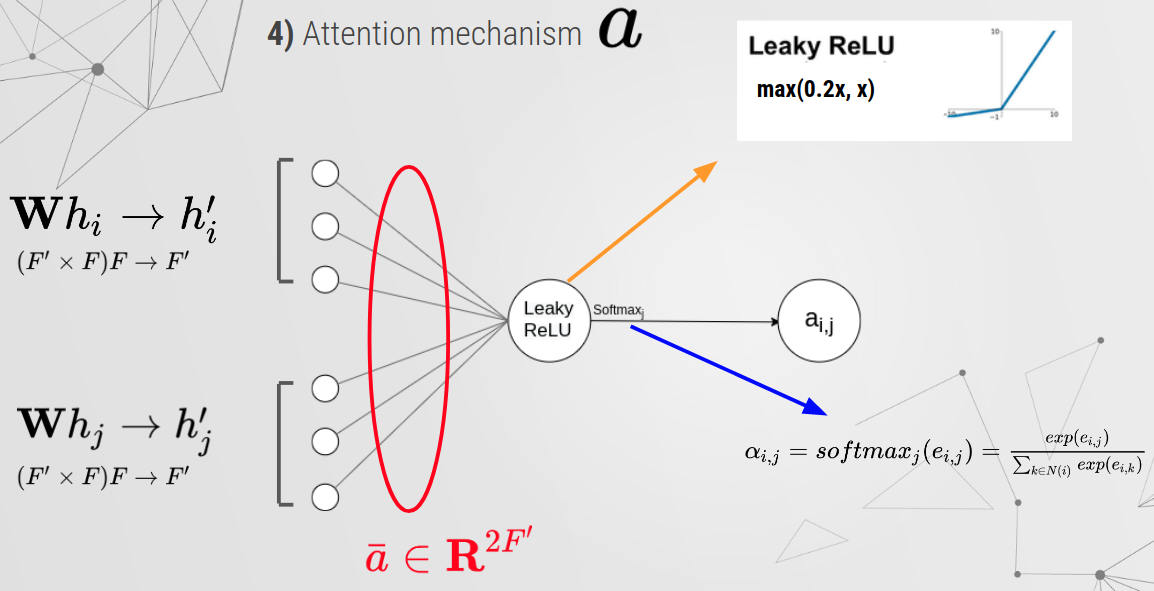

In [66]:
###################################################
## Step B: Calculate attention coefficients a_ij ##
###################################################

N = hW.size()[0]

a = nn.Parameter(torch.zeros(size=(2*out_features, 1))) # must be 2*out_features be cause we concatenate the inputs, doubling the size
nn.init.xavier_uniform_(a.data, gain=1.414) # xavier paramiter inizializator
print(a.shape)

leakyrelu = nn.LeakyReLU(0.2)  # LeakyReLU

a_input = torch.cat([hW.repeat(1, N).view(N * N, -1), hW.repeat(N, 1)], dim=1).view(N, -1, 2 * out_features)
print(a_input.shape)

torch.Size([4, 1])
torch.Size([3, 3, 4])


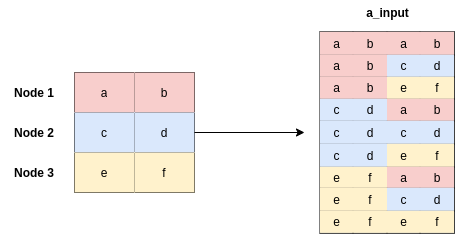

In [67]:
print(a_input)
# tensor([[[ 0.3335, -0.8133,  0.3335, -0.8133],     ab-ab
#          [ 0.3335, -0.8133,  0.1746, -0.6669],     ab-cd
#          [ 0.3335, -0.8133,  0.7886, -1.0117]],    ab-ef

#         [[ 0.1746, -0.6669,  0.3335, -0.8133],     cd-ab
#          [ 0.1746, -0.6669,  0.1746, -0.6669],     cd-cd
#          [ 0.1746, -0.6669,  0.7886, -1.0117]],    cd-ef

#         [[ 0.7886, -1.0117,  0.3335, -0.8133],     ef-ab
#          [ 0.7886, -1.0117,  0.1746, -0.6669],     ef-cd
#          [ 0.7886, -1.0117,  0.7886, -1.0117]]],   ef-ef
# grad_fn=<ViewBackward0>)

tensor([[[ 0.3318,  2.5227,  0.3318,  2.5227],
         [ 0.3318,  2.5227, -0.1508,  1.7665],
         [ 0.3318,  2.5227,  0.9974,  1.6837]],

        [[-0.1508,  1.7665,  0.3318,  2.5227],
         [-0.1508,  1.7665, -0.1508,  1.7665],
         [-0.1508,  1.7665,  0.9974,  1.6837]],

        [[ 0.9974,  1.6837,  0.3318,  2.5227],
         [ 0.9974,  1.6837, -0.1508,  1.7665],
         [ 0.9974,  1.6837,  0.9974,  1.6837]]], grad_fn=<ViewBackward0>)


In [68]:
#------------
## The attention coefficients
#------------

e = leakyrelu(torch.matmul(a_input, a).squeeze(2)) # .squeeze(2) to reduce the 1 in torch.Size([3, 3, 1])

print(a_input.shape, a.shape) # torch.Size([3, 3, 4]) torch.Size([4, 1])
print("")
print(torch.matmul(a_input, a).shape) # torch.Size([3, 3, 1]) = 3x4x4 @ 4x1
print("")
print(torch.matmul(a_input, a).squeeze(2).shape) # torch.Size([3, 3]), 3x3x1 -> 3x3
print("")
print(f"e matirx of attention coefs:\n{e}")

torch.Size([3, 3, 4]) torch.Size([4, 1])

torch.Size([3, 3, 1])

torch.Size([3, 3])

e matirx of attention coefs:
tensor([[1.1915, 1.6278, 1.9505],
        [0.3941, 0.8304, 1.1531],
        [0.0441, 0.4804, 0.8032]], grad_fn=<LeakyReluBackward0>)


### Masked Attention

In [69]:
#------------
## masked attention
#------------

torch.manual_seed(43)
adj = torch.randint(2, (3, 3)) # create a random adjacency matrix, values range from 0-1, with shape 3x3

zeros_tensor  = -9e15*torch.ones_like(e) # create a zeros_tensor containing very very small numbers (-9e15) that are close to 0

attention = torch.where(adj > 0, e, zeros_tensor) # Replace 1 in adj with e
                                              # Replace 0 in adj with the -9e15 (close to 0)
                                              # => results in an attention matrix with masked

print(f"adjacency matrix:\n{adj}")
print()
print(f"zeros_tensor close to 0:\n{zeros_tensor}")
print()
print(f"e matrix:\n{e}")
print()
print(f"attention matrix:\n{attention}")

adjacency matrix:
tensor([[0, 0, 1],
        [1, 1, 0],
        [0, 1, 1]])

zeros_tensor close to 0:
tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])

e matrix:
tensor([[1.1915, 1.6278, 1.9505],
        [0.3941, 0.8304, 1.1531],
        [0.0441, 0.4804, 0.8032]], grad_fn=<LeakyReluBackward0>)

attention matrix:
tensor([[-9.0000e+15, -9.0000e+15,  1.9505e+00],
        [ 3.9406e-01,  8.3039e-01, -9.0000e+15],
        [-9.0000e+15,  4.8044e-01,  8.0318e-01]], grad_fn=<WhereBackward0>)



In [70]:
#########################################
## Step C: Normalize a_ij with softmax ##
#########################################

attention_sftmx = F.softmax(attention, dim=1) # horizontally
print(f"attention softmax:\n{attention_sftmx}")

attention softmax:
tensor([[0.0000, 0.0000, 1.0000],
        [0.3926, 0.6074, 0.0000],
        [0.0000, 0.4200, 0.5800]], grad_fn=<SoftmaxBackward0>)


In [73]:
#########################
## STEP D: AGGREGATION ##
#########################
'''
h'_i = Sigma( alpha_ij * W * h_j ) # matrix dot product

here, h' is h_prime
      W * h_j = W @ h = Wh
'''

h_prime   = torch.matmul(attention_sftmx, hW) # Wh is torch.matmul(h, W)

print(f"h_prime:\n{h_prime}")
print()
print(f"hW:\n{hW}")

h_prime:
tensor([[0.9974, 1.6837],
        [0.0387, 2.0634],
        [0.5151, 1.7185]], grad_fn=<MmBackward0>)

hW:
tensor([[ 0.3318,  2.5227],
        [-0.1508,  1.7665],
        [ 0.9974,  1.6837]], grad_fn=<MmBackward0>)


# Build the layer (manually)

In [16]:
#################################
## Build GAT layers (manually) ##
#################################

class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout       = dropout        # drop prob = 0.6
        self.in_features   = in_features    # 
        self.out_features  = out_features   # 
        self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2
        self.concat        = concat         # conacat = True for all layers except the output layer.

        
        # Xavier Initialization of Weights
        # Alternatively use weights_init to apply weights of choice 
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        # LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]
        print(N)

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

# Build GAT layers with torch_geometric

In [ ]:
####################################
## Build GAT with torch_geometric ##
####################################

from torch_geometric.nn import GATConv
import torch

class GAT(torch.nn.Module):
    def __init__(self, dataset):
        super(GAT, self).__init__()
        torch.manual_seed(42)
        
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        
        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
                
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [74]:
##################
## Load dataset ##
##################

from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

root_path = '/home/longdpt/Documents/Long_AISDL/DeepLearning_PyTorch/05_GNN/data'

#---------
## Load the dataset
#---------

cora = Planetoid(root=root_path, name="Cora", transform=T.NormalizeFeatures())

print(f"Number of Classes in Cora:", cora.num_classes)
print(f"Number of Node Features in Cora", cora.num_node_features)

Number of Classes in Cora: 7
Number of Node Features in Cora 1433


In [75]:
######################
## Model initialize ##
######################    
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GAT(cora).to(device)
data = cora[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

In [76]:
###########
## Train ##
###########    

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    if epoch%200 == 0:
        print(loss)
    
    loss.backward()
    optimizer.step()

tensor(1.9477, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7640, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5391, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5730, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5447, device='cuda:0', grad_fn=<NllLossBackward0>)


In [77]:
##########
## Test ##
##########    

model.eval()

_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())

acc = correct / data.test_mask.sum().item()

print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8320
